In [1]:
# Import libraries
import numpy as np
import pandas as pd
import re

# load in Chembl data
processed_data = pd.read_csv("processed_data.csv")
# extract all descriptions as a list
descriptions = processed_data.description.to_list()

In [2]:
# Text preprocessing

# Remove punctuation
processed_data['descriptions_processed'] = \
processed_data['description'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
processed_data['descriptions_processed'] = \
processed_data['descriptions_processed'].map(lambda x: x.lower())
# Print out the first rows of papers
processed_data['descriptions_processed'].head()
# remove whitespcae from beginning or end of description strings
processed_data['descriptions_processed'] = processed_data['descriptions_processed'].str.strip()

In [3]:
# drop duplicate assays as rows were duplicated for each compound
processed_data = processed_data.drop_duplicates(subset=['descriptions_processed'])

In [5]:
# load in cell line ontology dataset with cell line synonyms and preferred labels
cell_line_ontology = pd.read_csv("cell_line_ontology.csv")
cell_line_ontology = cell_line_ontology.apply(lambda col: col.str.lower())
cell_line_ontology['Preferred Label'].replace('cell','', regex=True, inplace=True)

# explode synoynms column by splitting based on '|' separators
cell_line_ontology_expanded = cell_line_ontology['Synonyms'].str.split('|',expand=True)
cell_line_ontology_expanded[cell_line_ontology_expanded[0].str.contains('pc-3',na=False)]

# Create list of all synonyms in ontology dataset
# drop preferred label column and extract all dataframe values as an array
all_synonyms = cell_line_ontology_expanded.drop(columns=[0]).values.flatten() 
# remove None and np.nan from array
all_synonyms = [i for i in all_synonyms if (i is not np.nan) and (i is not None)] 

In [6]:
# Check if a string in list of synonyms is in descriptions_processed col, if yes then replace all instances of that synonym with prefered label
for synonym in all_synonyms:
    try:
        if len(processed_data[processed_data['descriptions_processed'].str.contains(synonym)]) > 0:
            # check if a substring is present
            row = cell_line_ontology[cell_line_ontology['Preferred Label'].str.contains(synonym)]
            preferred_label = row["Preferred Label"].to_list()[0].strip()
            # check if preferred label and synonym are identical strings, if yes -> move on to next iteration of loop
            if preferred_label == synonym:
                continue
            # replace all instances of term in descriptions column, if preferred label is present in 'descriptions_processed'
            if len(processed_data[processed_data['descriptions_processed'].str.contains(preferred_label)]) > 0: # find if preferred label is present in 'descriptions_processed'
                print(f"Prefered label:{preferred_label}, Synonym:{synonym}")
                processed_data['descriptions_processed'].replace(synoynm,preferred_label, regex=True, inplace=True)
    except:
        #print(synonym)
        pass

/tmp/3334629.1.short.q/ipykernel_131953/2392488238.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  if len(processed_data[processed_data['descriptions_processed'].str.contains(synonym)]) > 0:
/tmp/3334629.1.short.q/ipykernel_131953/2392488238.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  row = cell_line_ontology[cell_line_ontology['Preferred Label'].str.contains(synonym)]


Prefered label:nci-h1299, Synonym:h1299
Prefered label:testosterone, Synonym:testosteron
Prefered label:sk-mel-28, Synonym:sk.mel.28
Prefered label:u-87 mg, Synonym:u-87


/tmp/3334629.1.short.q/ipykernel_131953/2392488238.py:12: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  if len(processed_data[processed_data['descriptions_processed'].str.contains(preferred_label)]) > 0: # find if preferred label is present in 'descriptions_processed'


Prefered label:sk-mes-1, Synonym:sk-mes
Prefered label:mammary cancer, Synonym:mamma


In [4]:
# Some lines of code to normalise or remove description terms manually 
processed_data['descriptions_processed'].replace('in vitro','', regex=True, inplace=True)
processed_data['descriptions_processed'].replace('sulforhodamine b','srb', regex=True, inplace=True)
processed_data['descriptions_processed'].replace('sulforhodamine','srb', regex=True, inplace=True)
processed_data['descriptions_processed'].replace('pc3','pc-3', regex=True, inplace=True)

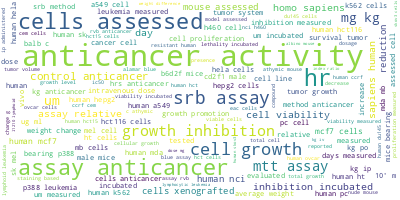

In [7]:
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(processed_data['descriptions_processed'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

## Levenshtein distance matrix (clustering descriptions without embeddings)

In [8]:
from Levenshtein import distance
text_distance = distance(processed_data['descriptions_processed'][0], processed_data['descriptions_processed'][100])
text_distance

66

In [9]:
distance_cols = processed_data.assay_chembl_id.to_list()
distance_index = processed_data.assay_chembl_id.to_list()

In [10]:
descriptions_list = processed_data.descriptions_processed

In [11]:
# set number of IDs to calculate distances for
n = len(descriptions_list)
# create list to store all lists of text distances
distance_frame = []
# iterate over list of descriptions, assign description as description_a
for description_a in descriptions_list[:n]:
    # create list to store all text distances for description_a
    distance_list = []
    # iterate over list of descriptions, assign description as description_b, for compariosn
    for description_b in descriptions_list[:n]:
        # calculate Levenshtein distance value between both descriptions
        text_distance = distance(description_a, description_b)
        # append value to list
        distance_list.append(text_distance)
    # append distance list for description_a to list of lists
    distance_frame.append(distance_list)

In [12]:
# create text difference matrix
text_difference_matrix = pd.DataFrame(distance_frame,columns=distance_cols[:n],index=distance_index[:n])
text_difference_matrix

,CHEMBL615198,CHEMBL615222,CHEMBL618440,CHEMBL619299,CHEMBL875586,CHEMBL620137,CHEMBL876492,CHEMBL620373,CHEMBL620374,CHEMBL620381,...,CHEMBL5217529,CHEMBL5217532,CHEMBL5217535,CHEMBL5217536,CHEMBL5217537,CHEMBL5217538,CHEMBL5217539,CHEMBL5217717,CHEMBL5217719,CHEMBL5217720
CHEMBL615198,0,3,13,8,28,34,11,8,11,35,...,63,39,74,73,75,72,94,77,93,139
CHEMBL615222,3,0,13,8,29,34,11,10,11,37,...,63,39,73,73,75,72,94,77,94,139
CHEMBL618440,13,13,0,8,28,36,7,12,7,46,...,61,39,73,73,73,73,94,75,89,137
CHEMBL619299,8,8,8,0,26,35,5,9,5,42,...,61,36,71,71,72,70,92,74,90,136
CHEMBL875586,28,29,28,26,0,26,27,27,22,39,...,65,42,75,74,76,73,99,75,95,139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CHEMBL5217538,72,72,73,70,73,74,70,70,71,91,...,66,42,6,6,8,0,35,42,98,106
CHEMBL5217539,94,94,94,92,99,102,93,91,93,120,...,40,67,34,36,34,35,0,71,113,118
CHEMBL5217717,77,77,75,74,75,76,74,74,74,95,...,70,58,43,43,45,42,71,0,97,64
CHEMBL5217719,93,94,89,90,95,96,89,94,91,86,...,101,90,100,98,101,98,113,97,0,115


### Clustering using distance matrix

In [13]:
from sklearn.cluster import AgglomerativeClustering

# Agglomerative clustering 
clustering = AgglomerativeClustering(n_clusters=100).fit(text_difference_matrix)

/share/apps/centos7/anaconda3/2022.05/lib/python3.9/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


In [14]:
clustering.labels_

array([27, 27, 27, ..., 18, 40, 14])

### Load embeddings data

In [15]:
import numpy as np
import pandas as pd

processed_data_embeddings = pd.read_csv("assays_with_embeddings.csv")
processed_data_embeddings

,Unnamed: 0,assay_chembl_id,assay_organism,assay_type,assay_type_description,description,compound_ids,clinical_trial_stages,embeddings
0,0,CHEMBL615198,NaN,F,Functional,In vitro anticancer activity against 2 NCI SCL...,CHEMBL37201,0.0,[ 0.12305924 0.28477192 -0.07695201 -0.202923...
1,1,CHEMBL615198,NaN,F,Functional,In vitro anticancer activity against 2 NCI SCL...,CHEMBL39385,0.0,[ 0.12305924 0.28477192 -0.07695201 -0.202923...
2,2,CHEMBL615198,NaN,F,Functional,In vitro anticancer activity against 2 NCI SCL...,CHEMBL39738,0.0,[ 0.12305924 0.28477192 -0.07695201 -0.202923...
3,3,CHEMBL615222,NaN,F,Functional,In vitro anticancer activity against 11 NCI NS...,CHEMBL37201,0.0,[ 2.21313611e-01 1.77551925e-01 -1.59558281e-...
4,4,CHEMBL615222,NaN,F,Functional,In vitro anticancer activity against 11 NCI NS...,CHEMBL39385,0.0,[ 2.21313611e-01 1.77551925e-01 -1.59558281e-...
...,...,...,...,...,...,...,...,...,...
37939,37939,CHEMBL5217719,Homo sapiens,T,Toxicity,"Selectivity index, ratio of IC50 for cytotoxic...",CHEMBL5220209,0.0,[ 7.99955353e-02 2.76694715e-01 1.01987291e-...
37940,37940,CHEMBL5217719,Homo sapiens,T,Toxicity,"Selectivity index, ratio of IC50 for cytotoxic...",CHEMBL5219358,0.0,[ 7.99955353e-02 2.76694715e-01 1.01987291e-...
37941,37941,CHEMBL5217719,Homo sapiens,T,Toxicity,"Selectivity index, ratio of IC50 for cytotoxic...",CHEMBL5220353,0.0,[ 7.99955353e-02 2.76694715e-01 1.01987291e-...
37942,37942,CHEMBL5217720,Homo sapiens,F,Functional,"Potency index, ratio of Sorafenib IC50 to test...",CHEMBL5220700,0.0,[-3.98075022e-03 3.43704343e-01 -4.78273705e-...


### Clean data

In [16]:
import itertools

# for some reason embeddings list is a string, needs to be converted
processed_data_embeddings['embeddings'].replace('\[','', regex=True, inplace=True)
processed_data_embeddings['embeddings'].replace('\]','', regex=True, inplace=True)
processed_data_embeddings['embeddings'].replace('\n','', regex=True, inplace=True)
processed_data_embeddings['embeddings'] = processed_data_embeddings['embeddings'].str.strip()
processed_data_embeddings['embeddings'] = processed_data_embeddings['embeddings'].str.split(' ')

# loops to remove empty elements from embeddings and converts embeddings to np array
new_embeddings = []
for embedding_list in processed_data_embeddings['embeddings'].values:
    # using lambda function
    embedding_list_ = list(itertools.filterfalse(lambda x: x == '', embedding_list))
    # convert list to np array
    embedding_array = np.array(embedding_list_)
    # cast elements to float
    embedding_array = embedding_array.astype(float) 
    # append to list of arrays
    new_embeddings.append(embedding_array)
    
# swap in reformatted embeddings
processed_data_embeddings['embeddings'] = new_embeddings

In [17]:
# shape of embedding
print(processed_data_embeddings['embeddings'][3].shape)

(700,)


### Find embeddings distance and create distance matrix

In [18]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

In [19]:
# Word embeddings for two words
word1_embedding = processed_data_embeddings['embeddings'][0]
word2_embedding = processed_data_embeddings['embeddings'][1000]
# Reshape the arrays to match the expected input shape of cosine_similarity
word1_embedding = word1_embedding.reshape(1, -1)
word2_embedding = word2_embedding.reshape(1, -1)
# Calculate cosine similarity
similarity = cosine_similarity(word1_embedding, word2_embedding)[0][0]
print(similarity)

0.47609028494758204


In [20]:
# for speed, drop duplicate assays as rows were duplicated for each compound
processed_data_embeddings = processed_data_embeddings.drop_duplicates(subset=['assay_chembl_id'])

In [21]:
similarity_cols = processed_data_embeddings.assay_chembl_id.to_list()
similarity_index = processed_data_embeddings.assay_chembl_id.to_list()
embeddings_list = processed_data_embeddings.embeddings

In [ ]:
# set number of IDs to calculate cosine similarity for
n = len(embeddings_list)
# create list to store all lists of embedding similarities
similarity_frame = []
# iterate over list of embeddings, assign embedding as embedding_a
for count, embedding_a in enumerate(embeddings_list[:n],1):
    # create list to store all embedding cosine similarities for embedding_a
    similarity_list = []
    # iterate over list of embeddings, assign embedding as embedding_b, for compariosn
    for embedding_b in embeddings_list[:n]:
        # Reshape the arrays to match the expected input shape of cosine_similarity
        embedding_a = embedding_a.reshape(1, -1)
        embedding_b = embedding_b.reshape(1, -1)
        # Calculate cosine similarity
        similarity = cosine_similarity(embedding_a, embedding_b)[0][0]
        # append value to list
        similarity_list.append(similarity)
    # append similarity list for embedding_a to list of lists
    similarity_frame.append(similarity_list)
    # print count if multiple of 100
    if count % 500 == 0:
        print(f"Iteration {count}")

Iteration 500


In [ ]:
# create cosine similarity matrix
cosine_similarity_matrix = pd.DataFrame(similarity_frame,columns=similarity_cols[:n],index=similarity_index[:n])
cosine_similarity_matrix

### Clustering using similarity matrix

In [ ]:
from sklearn.cluster import AgglomerativeClustering

# Agglomerative clustering 
clustering = AgglomerativeClustering(n_clusters=200).fit(cosine_similarity_matrix)

In [ ]:
# subset for example chembl IDs
data_subset = processed_data_embeddings[processed_data_embeddings['assay_chembl_id'].isin(cosine_similarity_matrix.columns)] 

In [ ]:
data_subset['embedding_cluster'] = clustering.labels_

In [ ]:
# histogram plot to check distribution (should be relatively even, if not, clustering is likely bad)
from matplotlib import pyplot as plt 
import numpy as np  
   
plt.hist(clustering.labels_) 
plt.title("histogram") 
plt.show()

In [ ]:
# check if clustering is giving useful groupings
for row in data_subset[data_subset.embedding_cluster==25]['description']:
    print(row)

In [ ]:
# N: Will need to make it so that cluster is added to all instances of matching ChEMBL ID
# ... will implement later